In [1]:
import numpy as np
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
cover_analysis = pl.read_csv("tabular_data/cover_analysis_tabular.csv")
benchmark = pl.read_csv("tabular_data/benchmark_tabular.csv")

In [3]:
cover_analysis.shape, len(cover_analysis["work"].unique())

((10000, 54), 5000)

In [4]:
benchmark.shape, len(benchmark["work"].unique())

((15000, 54), 3000)

In clustering scenarios, there are two popular methods that help determine the optimal number of clusters, the "Elbow" method and the Silhouette score method. In both of these methods you have to observe how key value changes w.r.t. the number of clusters.

In [8]:
wcss = []
silhouette_scores = []

scaler = StandardScaler()

x_scaled_c = scaler.fit_transform(cover_analysis.drop(["work", "performance"]))
x_scaled_b = scaler.transform(benchmark.drop(["work", "performance"]))

k_range = range(200, 8001, 200)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, init="random", n_init=10, random_state=0)

    clusters_c = kmeans.fit_predict(x_scaled_c)
    clusters_b = kmeans.predict(x_scaled_b)

    score = silhouette_score(x_scaled_c, clusters_c)
    if k in [400, 1200, 3000]:
        cover_analysis = cover_analysis.with_columns(clusters=clusters_c)
        cover_analysis = cover_analysis.with_columns(
            pl.col("clusters").alias(f"clusters_{k}")
        )

        benchmark = benchmark.with_columns(clusters=clusters_b)
        benchmark = benchmark.with_columns(pl.col("clusters").alias(f"clusters_{k}"))
    else:
        kmeans.fit(x_scaled_c)

    wcss.append(kmeans.inertia_)
    silhouette_scores.append(score)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [03:01<00:00,  4.53s/it]


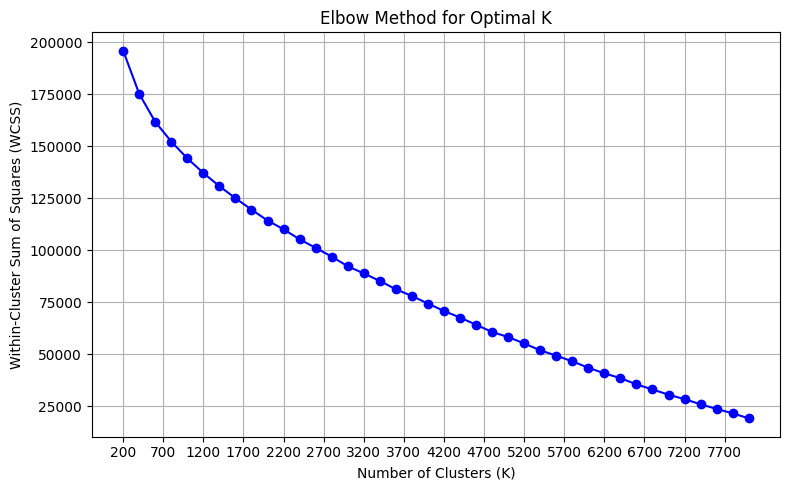

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.xticks(np.arange(min(k_range), max(k_range), step=500))
plt.grid()
plt.tight_layout()
plt.show()

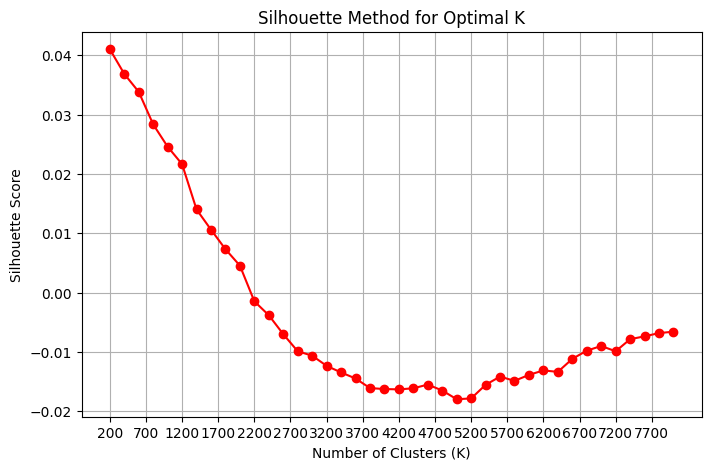

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker="o", linestyle="-", color="r")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal K")
plt.xticks(np.arange(min(k_range), max(k_range), step=500))  # Adjust tick intervals
plt.grid()
plt.show()

The Eblow method and the Silhouette score are methods used to find the optimal number of clusters in situations like this. In the first method, the optimal number of clusters is selected by finding the point where the WCSS has a local minimum. In our case though, WCSS seems to decrease as we increase the number of clusters. As far as our second option is concerned, the optimal number of clusters is selected by judging the Silhouette score plot. In this case, the higher score the better and more specifically we observe that as we decrease the number of clusters the score increases, a pattern that seems to be supported by our next analysis.

In [12]:
kmeans = KMeans(n_clusters=5000, init="random", n_init=10, random_state=0)

clusters = kmeans.fit_predict(x_scaled_c)

cover_analysis = cover_analysis.with_columns(clusters=clusters)
cover_analysis = cover_analysis.with_columns(pl.col("clusters").alias("clusters_5000"))

In [13]:
kmeans = KMeans(n_clusters=20, init="random", n_init=10, random_state=0)

clusters = kmeans.fit_predict(x_scaled_c)

cover_analysis = cover_analysis.with_columns(clusters=clusters)
cover_analysis = cover_analysis.with_columns(pl.col("clusters").alias("clusters_20"))

cover_analysis = cover_analysis.drop("clusters")

What we would at least want from the clustering procedure is that cover songs that belong to the same clique to be assigned to the same cluster. So in the perfect scenario there should be 5000 clusters, one for each clique. By assigning 5000 clusters to the KMeans algorithm this is nowhere near true and it is clear that cover songs of the same clique belong to different clusters.

In [14]:
cover_analysis.group_by(["work", "clusters_5000"]).len().sort("work")

work,clusters_5000,len
str,i32,u32
"""W_100010""",1688,1
"""W_100010""",2704,1
"""W_100027""",4866,1
"""W_100027""",2161,1
"""W_100108""",2980,1
…,…,…
"""W_99942""",2420,1
"""W_99974""",4620,1
"""W_99974""",213,1


If the cluster and the clique had a 1-1 relationship the result of the above operation would be a table of shape (5000, 3). We can see that by lowering the number of clusters, we come closer to that shape. But that is normal, because we essentially we increase the size of the clusters.

In [15]:
cover_analysis.group_by(["work", "clusters_3000"]).len().shape

(9784, 3)

In [16]:
cover_analysis.group_by(["work", "clusters_1200"]).len().shape

(9658, 3)

In [17]:
cover_analysis.group_by(["work", "clusters_400"]).len().shape

(9539, 3)

In [18]:
cover_analysis.group_by(["work", "clusters_20"]).len().shape

(8684, 3)

All in all, this relatively simple machine learning algorithm is not quite good for this task. For the sake of completion lets make the same "test" in the benchmark dataset also.

In [20]:
benchmark.group_by(["work", "clusters_3000"]).len().shape

(14263, 3)

In [19]:
benchmark.group_by(["work", "clusters_1200"]).len().shape

(13925, 3)

In [21]:
benchmark.group_by(["work", "clusters_400"]).len().shape

(13238, 3)